In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The stars
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Es momento de un juego de arquitecturas. Vamos a trabajar con un dataset de Kaggle, el [FIFA19 dataset](https://www.kaggle.com/karangadiya/fifa19). De los notebooks tambien saque algunos codigos copados.

In [2]:
import pandas as pd
!wget http://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/datasets/data_FIFA19.csv
data_FIFA=pd.read_csv('data_FIFA19.csv')
data_FIFA.info()

--2020-10-27 19:37:25--  http://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/datasets/data_FIFA19.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/datasets/data_FIFA19.csv [following]
--2020-10-27 19:37:25--  https://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/master/datasets/data_FIFA19.csv
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9140113 (8.7M) [text/plain]
Saving to: ‘data_FIFA19.csv’

data_FIFA19.csv     100%[===================>]   8.72M  17.7MB/s    in 0.5s    

2020-10-27 19:37:26 (17.7 MB/s) - ‘data_FIFA19.csv’ saved [9140113/9140113]

<class 'pandas.core.f

El objetivo va a ser obtener el Player Overall Ranking a partir de las distintas caracteristicas de los jugadores.

Hagamos un preprocesado rapido. Basicamente colapso las posiciones a una columna de 0,1,2 y tiro un monton de otras cosas.

In [6]:
df = data_FIFA.copy()
drop_cols = df.columns[28:54]
df = df.drop(drop_cols, axis = 1)
df = df.drop(['Unnamed: 0','ID','Photo','Flag','Club Logo','Jersey Number','Joined','Special','Loaned From','Body Type', 'Release Clause',
               'Weight','Height','Contract Valid Until','Wage','Value','Club'], axis = 1)
df = df.dropna()
df.head()

,Name,Age,Nationality,Overall,Potential,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Real Face,Position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,L. Messi,31,Argentina,94,94,Left,5.0,4.0,4.0,Medium/ Medium,Yes,RF,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,Cristiano Ronaldo,33,Portugal,94,94,Right,5.0,4.0,5.0,High/ Low,Yes,ST,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,Neymar Jr,26,Brazil,92,93,Right,5.0,5.0,5.0,High/ Medium,Yes,LW,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,De Gea,27,Spain,91,93,Right,4.0,3.0,1.0,Medium/ Medium,Yes,GK,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,K. De Bruyne,27,Belgium,91,92,Right,4.0,5.0,4.0,High/ High,Yes,RCM,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [7]:
def right_footed(df):
    if (df['Preferred Foot'] == 'Right'):
        return 1
    else:
        return 0

#Create a simplified position varaible to account for all player positions
def simple_position(df):
    if (df['Position'] == 'GK'):
        return 0
    elif ((df['Position'] == 'RB') | (df['Position'] == 'LB') | (df['Position'] == 'CB') | (df['Position'] == 'LCB') | (df['Position'] == 'RCB') | (df['Position'] == 'RWB') | (df['Position'] == 'LWB') ):
        return 1
    elif ((df['Position'] == 'LDM') | (df['Position'] == 'CDM') | (df['Position'] == 'RDM')):
        return 2
    elif ((df['Position'] == 'LM') | (df['Position'] == 'LCM') | (df['Position'] == 'CM') | (df['Position'] == 'RCM') | (df['Position'] == 'RM')):
        return 2
    elif ((df['Position'] == 'LAM') | (df['Position'] == 'CAM') | (df['Position'] == 'RAM') | (df['Position'] == 'LW') | (df['Position'] == 'RW')):
        return 2
    elif ((df['Position'] == 'RS') | (df['Position'] == 'ST') | (df['Position'] == 'LS') | (df['Position'] == 'CF') | (df['Position'] == 'LF') | (df['Position'] == 'RF')):
        return 3
    else:
        return df.Position

df['Right_Foot'] = df.apply(right_footed, axis=1)
df['Simple_Position'] = df.apply(simple_position,axis = 1)

#Split the Work Rate Column in two
tempwork = df["Work Rate"].str.split("/ ", n = 1, expand = True) 
#Create new column for first work rate
df["WorkRate1"]= tempwork[0]   
#Create new column for second work rate
df["WorkRate2"]= tempwork[1]
#Drop original columns used
df = df.drop(['Work Rate','Preferred Foot','Real Face', 'Position','Nationality'], axis = 1)
df.head()

,Name,Age,Overall,Potential,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Right_Foot,Simple_Position,WorkRate1,WorkRate2
0,L. Messi,31,94,94,5.0,4.0,4.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,0,3,Medium,Medium
1,Cristiano Ronaldo,33,94,94,5.0,4.0,5.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,1,3,High,Low
2,Neymar Jr,26,92,93,5.0,5.0,5.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,1,2,High,Medium
3,De Gea,27,91,93,4.0,3.0,1.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,1,0,Medium,Medium
4,K. De Bruyne,27,91,92,4.0,5.0,4.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,1,2,High,High


Vamos a separar en un par de subgrupos. El target es el Overall.

In [8]:
y=np.asarray(df['Overall'])
name=np.asarray(df['Name'])
print(y.shape,name.shape)

(18147,) (18147,)


Y primero vamos a utilizar unicamente los skills del jugador que son verdaderamente numericos

In [9]:
num_cols=df.columns[4:-4]
df_num=df[num_cols]
df_num.head()

,International Reputation,Weak Foot,Skill Moves,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,5.0,4.0,4.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,5.0,4.0,5.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,5.0,5.0,5.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,4.0,3.0,1.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,4.0,5.0,4.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
df_num=np.asarray(df_num)
print(df_num.shape)

(18147, 37)


Y ahora quedemonos con el Simple Position para despues

In [11]:
df_pos=np.asarray(df['Simple_Position']).reshape(-1,1)
df_pos.shape

(18147, 1)

Y dividamos todo bien:

In [12]:
X_num_train_full, X_num_test,X_pos_train_full, X_pos_test, y_train_full, y_test = train_test_split(df_num,df_pos, y, random_state=42)
X_num_train, X_num_valid, X_pos_train, X_pos_valid, y_train, y_valid = train_test_split(X_num_train_full, X_pos_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_num_train)
X_num_valid = scaler.transform(X_num_valid)
X_num_test = scaler.transform(X_num_test)

Antes que nada, hagamos una regresion lineal para usar de baseline

6.2261802888847875 0.10492479439912228
6.296815946479954


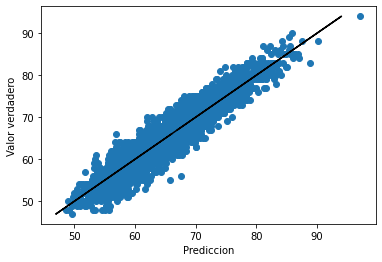

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
lr = LinearRegression()
scores = cross_val_score(lr, scaler.transform(X_num_train_full),y_train_full,scoring='neg_mean_squared_error')
print(-scores.mean(),scores.std())
lr.fit(X_num_train,y_train)
y_predict=lr.predict(X_num_valid)
plt.scatter(y_predict,y_valid)
plt.plot(y_valid,y_valid,color='black')
plt.xlabel('Prediccion')
plt.ylabel('Valor verdadero')
print(mean_squared_error(y_valid,y_predict))

Utilicemos una Red Neuronal con las siguientes caracteristicas:

- Una unica capa oculta de 10 neuronas, con activacion 'relu' e iniciacion 'he_normal'
- Una capa de salida con activacion 'relu' e iniciacion 'he_normal'

Entrene con error 'mse', SGD con learning rate 0.001,  batch_size=100, 200 epocas y un early_stopping de paciencia 10.

In [32]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
X_num_train.shape[1]

37

In [33]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(10,activation='relu',kernel_initializer='he_normal',input_shape=X_num_train.shape[1:]))
model.add(keras.layers.Dense(1,activation='relu',kernel_initializer='he_normal'))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                380       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________


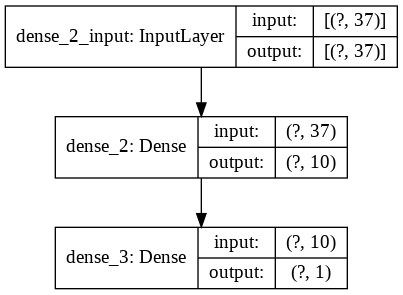

In [24]:
keras.utils.plot_model(model,show_shapes=True)

In [35]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history = model.fit(X_num_train,y_train,batch_size=100,epochs=200,validation_data=(X_num_valid,y_valid),callbacks=[early_stopping_cb])

Epoch 1/200
103/103 [==============================] - 0s 2ms/step - loss: 773.4954 - val_loss: 54.6869
Epoch 2/200
103/103 [==============================] - 0s 1ms/step - loss: 36.5689 - val_loss: 30.8657
Epoch 3/200
103/103 [==============================] - 0s 1ms/step - loss: 24.9140 - val_loss: 23.4241
Epoch 4/200
103/103 [==============================] - 0s 1ms/step - loss: 18.8237 - val_loss: 16.7622
Epoch 5/200
103/103 [==============================] - 0s 1ms/step - loss: 14.6313 - val_loss: 16.2670
Epoch 6/200
103/103 [==============================] - 0s 1ms/step - loss: 11.4183 - val_loss: 14.6783
Epoch 7/200
103/103 [==============================] - 0s 1ms/step - loss: 8.8611 - val_loss: 8.3943
Epoch 8/200
103/103 [==============================] - 0s 1ms/step - loss: 7.0506 - val_loss: 6.8097
Epoch 9/200
103/103 [==============================] - 0s 1ms/step - loss: 5.8233 - val_loss: 5.5413
Epoch 10/200
103/103 [==============================] - 0s 1ms/step - loss: 4.

1.0540627280040726


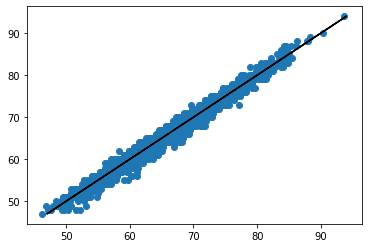

In [36]:
y_predict=model.predict(X_num_valid)
plt.scatter(y_predict,y_valid)
plt.plot(y_valid,y_valid,color='black')
print(mean_squared_error(y_valid,y_predict))

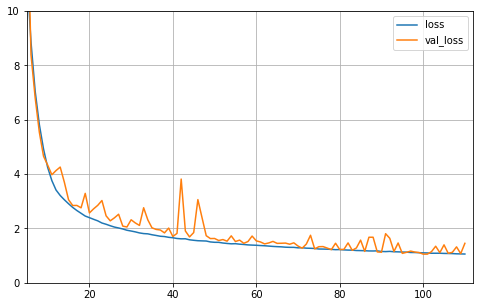

In [39]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.gca().set_xlim(5, 112)
plt.show()

Podemos bajar un poco el numero de parametros con un pequenio truco, las skip connections. La arquitectura es la siguiente

- Dos capas ocultas de 2 neuronas, con activacion 'relu' e iniciacion 'he_normal' que ven al input
- Una capa de salida con activacion 'relu' e iniciacion 'he_normal' que tambien ve al input

Entrene con error 'mse', Adam con learning rate de 0.01, batch_size=100, 250 epocas y un early_stopping de paciencia 10.

In [51]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [52]:
input_ = keras.layers.Input(shape=X_num_train.shape[1:])
hidden1 = keras.layers.Dense(2,activation='relu',kernel_initializer='he_normal',name='Hidden_1')(input_)
hidden2 = keras.layers.Dense(2,activation='relu',kernel_initializer='he_normal',name='Hidden_2')(keras.layers.concatenate([hidden1,input_]))
output_ = keras.layers.Dense(1,activation='relu',kernel_initializer='he_normal',name='Output')(keras.layers.concatenate([hidden2,input_]))
model=keras.models.Model(inputs=[input_],outputs=[output_])

In [53]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
Hidden_1 (Dense)                (None, 2)            76          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 39)           0           Hidden_1[0][0]                   
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
Hidden_2 (Dense)                (None, 2)            80          concatenate[0][0]     

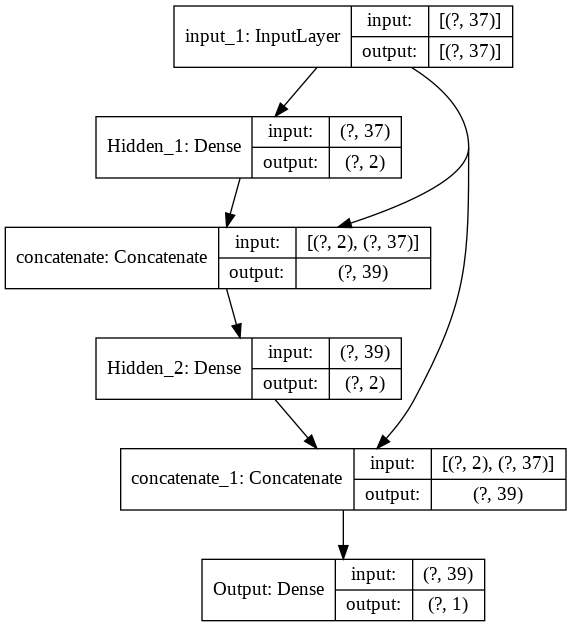

In [49]:
keras.utils.plot_model(model,show_shapes=True)

In [55]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-3))
early_stopping_cb=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
history = model.fit(X_num_train,y_train,batch_size=100,epochs=250,validation_data=(X_num_valid,y_valid),callbacks=[early_stopping_cb])

Epoch 1/250
103/103 [==============================] - 0s 3ms/step - loss: 1.7051 - val_loss: 1.6220
Epoch 2/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6829 - val_loss: 1.6550
Epoch 3/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6996 - val_loss: 1.6123
Epoch 4/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6942 - val_loss: 1.6233
Epoch 5/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6911 - val_loss: 1.6445
Epoch 6/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6974 - val_loss: 1.6233
Epoch 7/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6985 - val_loss: 1.6206
Epoch 8/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6860 - val_loss: 1.6388
Epoch 9/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6803 - val_loss: 1.6317
Epoch 10/250
103/103 [==============================] - 0s 2ms/step - loss: 1.6794 - val_lo

1.5709621238046179


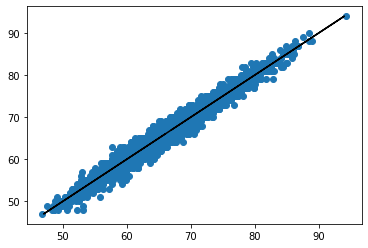

In [56]:
y_predict=model.predict(X_num_valid)
plt.scatter(y_predict,y_valid)
plt.plot(y_valid,y_valid,color='black')
print(mean_squared_error(y_valid,y_predict))

Ahora, podemos mejorar esto de una manera sutil. Incorporemos un segundo output, la posicion. La idea es que buscando tanto interpolar el Overall y clasificar la posicion, la red neuronal sea todavia mejor.

Altere la arquitectura previa pero ahora utilice dos capas de outputs, agregando a la ya existente una con softmax e inicializacion Glorot uniforme.

Al compilar, hay que cambiar loss='mean_squared_error' por loss=['mean_squared_error','sparse_categorical_cross_entropy'] y agregar un loss_weight=[0.5,0.5]. El loss_weight marca el peso relativo entre los problemas. Si ponemos [0.9,0.1], el problema de clasificacion juega el rol de regularizacion. No nos interesa demasiado eso ya que no sobreajustamos tanto.

Al entrenar, hay que alimentar con dos outputs [y_train,X_pos_train], y lo mismo en validacion.

In [57]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [58]:
input_ = keras.layers.Input(shape=X_num_train.shape[1]) #En este caso es necesario definir el Layer de Inputs
hidden_layer_1 = keras.layers.Dense(2, activation="relu",kernel_initializer='he_normal')
hidden1=hidden_layer_1(input_)#
hidden_layer_2 = keras.layers.Dense(2, activation="relu",kernel_initializer='he_normal')
hidden2 = hidden_layer_2(keras.layers.concatenate([input_, hidden1]))
hidden_layer_3 = keras.layers.Dense(1, activation="relu",kernel_initializer='he_normal')
output_num = hidden_layer_3(keras.layers.concatenate([input_, hidden2]))#
output_pos = keras.layers.Dense(4, activation="softmax",kernel_initializer='glorot_uniform')(keras.layers.concatenate([input_, hidden2]))
model = keras.models.Model(inputs=[input_], outputs=[output_num,output_pos])

In [59]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2)            76          input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 39)           0           input_1[0][0]                    
                                                                 dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            80          concatenate[0][0]     

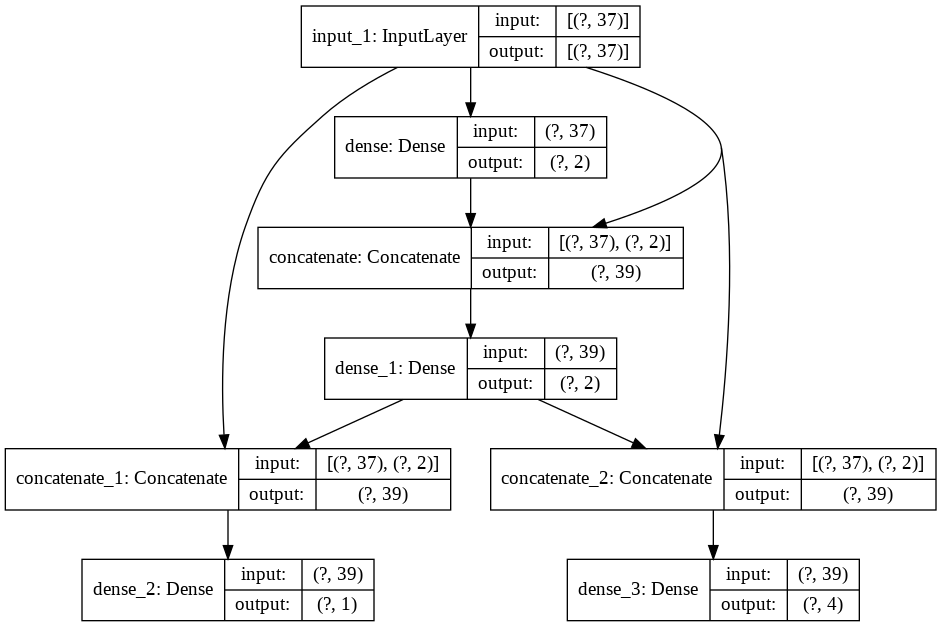

In [60]:
keras.utils.plot_model(model,show_shapes=True)

In [61]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
model.compile(loss=["mean_squared_error","sparse_categorical_crossentropy"],loss_weights=[0.5,0.5], optimizer=keras.optimizers.Adam())
history = model.fit(X_num_train, [y_train,X_pos_train], batch_size=100,epochs=250,
                    validation_data=(X_num_valid,[y_valid,X_pos_valid]),callbacks=[early_stopping_cb])

Epoch 1/250
103/103 [==============================] - 0s 3ms/step - loss: 2160.8276 - dense_2_loss: 4320.4160 - dense_3_loss: 1.2394 - val_loss: 2118.2229 - val_dense_2_loss: 4235.5908 - val_dense_3_loss: 0.8552
Epoch 2/250
103/103 [==============================] - 0s 2ms/step - loss: 2085.9241 - dense_2_loss: 4171.1118 - dense_3_loss: 0.7372 - val_loss: 2028.0210 - val_dense_2_loss: 4055.4297 - val_dense_3_loss: 0.6124
Epoch 3/250
103/103 [==============================] - 0s 2ms/step - loss: 1987.6671 - dense_2_loss: 3974.7600 - dense_3_loss: 0.5735 - val_loss: 1919.6384 - val_dense_2_loss: 3838.7798 - val_dense_3_loss: 0.4970
Epoch 4/250
103/103 [==============================] - 0s 2ms/step - loss: 1876.1605 - dense_2_loss: 3751.8386 - dense_3_loss: 0.4820 - val_loss: 1803.7405 - val_dense_2_loss: 3607.0562 - val_dense_3_loss: 0.4249
Epoch 5/250
103/103 [==============================] - 0s 2ms/step - loss: 1756.3002 - dense_2_loss: 3512.1753 - dense_3_loss: 0.4238 - val_loss: 16

1.606223346646156


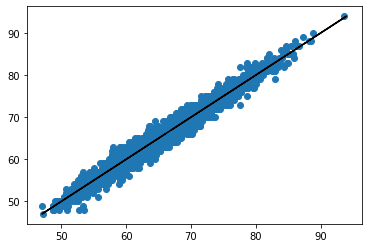

In [62]:
y_predict, pos_predict = model.predict(X_num_valid)
plt.scatter(y_predict,y_valid)
plt.plot(y_valid,y_valid,color='black')
print(mean_squared_error(y_valid,y_predict))

In [63]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(X_pos_valid,np.argmax(pos_predict,axis=1))
cm

array([[ 396,    0,    0,    0],
       [   0, 1045,   74,    0],
       [   0,   97, 1238,   62],
       [   0,    0,   71,  420]])